# Load Data

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d moltean/fruits
!ls

#Prepare Data

In [0]:
!unzip fruits.zip

# Prepare Loader

In [0]:
import torch
from torchvision import datasets, transforms, models
import numpy as np
from matplotlib import pyplot as plt

In [9]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_dir = "fruits-360/"

train_transform = transforms.Compose([
                                transforms.Resize(150),
                                transforms.RandomResizedCrop(140),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
                                transforms.Resize(150),
                                transforms.CenterCrop(150),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

train_data  = datasets.ImageFolder(data_dir + '/Training', train_transform)
test_data = datasets.ImageFolder(data_dir + '/Test', test_transform)
len(train_data)

57276

In [4]:
classes = train_data.classes
class_idx = train_data.class_to_idx
len(class_idx)

114

In [6]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=200,
                                           shuffle=True,
                                           num_workers=1)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=200,
                                          shuffle=False,
                                          num_workers=1)

print(len(train_loader))

287


# Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


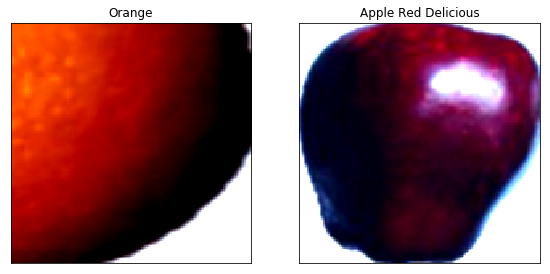

In [7]:
# visualize data
import numpy as np
import matplotlib.pyplot as plt

data_iter = iter(train_loader)
images, labels = data_iter.next()

fig = plt.figure(figsize=(25, 5))
for idx in range(2):
    ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
    # unnormolaize first
    img = images[idx] / 2 + 0.5
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0)) #transpose
    ax.imshow(img, cmap='gray')
    ax.set_title(classes[labels[idx]])

# Prepare Model

In [8]:
model = models.vgg16(pretrained=True)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [0]:
for param in model.parameters():
    param.required_grad = False

In [11]:
import torch.nn as nn
from collections import OrderedDict

classifier = nn.Sequential(
  nn.Linear(in_features=25088, out_features=4096),
  nn.ReLU(),
  nn.Dropout(p=0.2),
  nn.Linear(in_features=4096, out_features=1024),
  nn.ReLU(),
  nn.Dropout(p=0.3),
  nn.Linear(in_features=1024, out_features=114),
  nn.LogSoftmax(dim=1)  
)
    
model.classifier = classifier
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=4096, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3)
  (6): Linear(in_features=1024, out_features=114, bias=True)
  (7): LogSoftmax()
)

In [12]:
import torch.optim as optim
import torch

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
#gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

#Train

In [15]:
from tqdm import tqdm 
epochs = 2
steps = 0
running_loss = 0
print_every = 100
# compare overfited
train_loss_data,valid_loss_data = [],[]

for epoch in tqdm(range(epochs)):
    for inputs, labels in train_loader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            running_loss = 0
            model.train()
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = running_loss/len(train_loader.dataset)
    valid_loss = test_loss/len(test_loader.dataset)
    
    #clculate train loss and running loss
    train_loss_data.append(train_loss)
    valid_loss_data.append(valid_loss)



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2.. Train loss: 0.854.. Test loss: 0.392.. Test accuracy: 0.884
Epoch 1/2.. Train loss: 0.799.. Test loss: 0.488.. Test accuracy: 0.886




 50%|█████     | 1/2 [09:18<09:18, 558.01s/it]

Epoch 2/2.. Train loss: 0.793.. Test loss: 0.340.. Test accuracy: 0.902
Epoch 2/2.. Train loss: 0.737.. Test loss: 0.305.. Test accuracy: 0.910
Epoch 2/2.. Train loss: 0.735.. Test loss: 0.365.. Test accuracy: 0.906




100%|██████████| 2/2 [19:29<00:00, 574.00s/it]



# Test per class

In [16]:
# track test loss

total_class = 114

test_loss = 0.0
class_correct = list(0. for i in range(total_class))
class_total = list(0. for i in range(total_class))

with torch.no_grad():
  model.eval()
  # iterate over test data
  for data, target in test_loader:
      # move tensors to GPU if CUDA is available
      data, target = data.to(device), target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # update test loss 
      test_loss += loss.item()*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(16):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(total_class):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.295710

Test Accuracy of Apple Braeburn: 81% (13/16)
Test Accuracy of Apple Crimson Snow: 100% (16/16)
Test Accuracy of Apple Golden 1: 93% (15/16)
Test Accuracy of Apple Golden 2: 100% (16/16)
Test Accuracy of Apple Golden 3: 100% ( 1/ 1)
Test Accuracy of Apple Granny Smith: 100% (15/15)
Test Accuracy of Apple Pink Lady: 18% ( 3/16)
Test Accuracy of Apple Red 1: 62% (10/16)
Test Accuracy of Apple Red 2: 87% (14/16)
Test Accuracy of Apple Red 3: N/A (no training examples)
Test Accuracy of Apple Red Delicious: 100% (16/16)
Test Accuracy of Apple Red Yellow 1: 81% (13/16)
Test Accuracy of Apple Red Yellow 2: 18% ( 3/16)
Test Accuracy of Apricot: 100% (16/16)
Test Accuracy of Avocado: 100% (16/16)
Test Accuracy of Avocado ripe: 100% (11/11)
Test Accuracy of Banana: 100% ( 5/ 5)
Test Accuracy of Banana Lady Finger: 100% (16/16)
Test Accuracy of Banana Red: 100% (16/16)
Test Accuracy of Blueberry: 18% ( 3/16)
Test Accuracy of Cactus fruit: 100% (15/15)
Test Accuracy of Cantalou

# Test

Plum


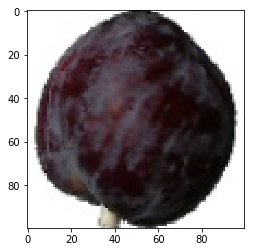

In [18]:
import os
from glob import glob
import numpy as np  # linear algebra
import torch
from PIL import Image
from matplotlib import pyplot as plt

file =  data_dir + "Test/Plum/44_100.jpg"

classes = train_loader.dataset.class_to_idx

with Image.open(file) as f:
    img = test_transform(f).unsqueeze(0)
    with torch.no_grad():
        out = model(img.to(device)).cpu().numpy()
        for key, value in classes.items():
            if value == np.argmax(out):
                print(key)
        plt.imshow(np.array(f))
        plt.show()

fruits-360/Test/Salak/145_100.jpg
Salak


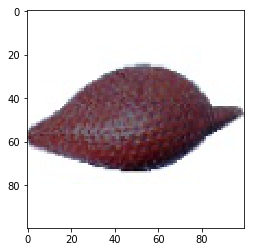

In [19]:
file =  data_dir + "Test/Salak/145_100.jpg"
print(file)

classes = train_loader.dataset.class_to_idx

with Image.open(file) as f:
    img = test_transform(f).unsqueeze(0)
    with torch.no_grad():
        out = model(img.to(device)).cpu().numpy()
        for key, value in classes.items():
            if value == np.argmax(out):
                print(key)
        plt.imshow(np.array(f))
        plt.show()

# Test with new transform

In [0]:
def test(file):
  valid_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

  classes = train_loader.dataset.class_to_idx

  with Image.open(file) as f:
      img = valid_transform(f).unsqueeze(0)
      with torch.no_grad():
          out = model(img.to(device)).cpu().numpy()
          for key, value in classes.items():
              if value == np.argmax(out):
                  print(f"Predicted Label:{key}")
          plt.imshow(np.array(f))
          plt.show()

fruits-360/Test/Guava/100_100.jpg
Predicted Label:Guava


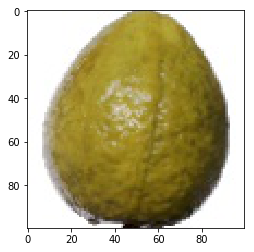

In [84]:
file =  data_dir + "Test/Guava/100_100.jpg"
print(file)
test(file)

#Multiple Fruit Detection


fruits-360/test-multiple_fruits/apple.jpg
Predicted Label:Apple Golden 2


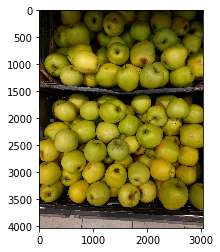

In [85]:
file =  data_dir + "test-multiple_fruits/apple.jpg"
print(file)
test(file)

fruits-360/test-multiple_fruits/mango.jpg
Realy Label: Mango
Predicted Label:Plum 3


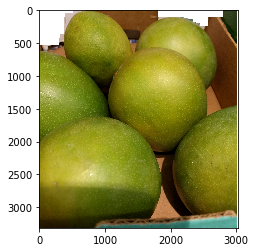

In [86]:
file =  data_dir + "test-multiple_fruits/mango.jpg"
print(file)
print("Realy Label: Mango")
test(file)

fruits-360/test-multiple_fruits/tomatoes1.jpg
Realy Label: tomatoes
Predicted Label:Kohlrabi


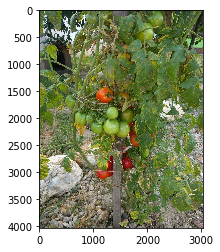

In [88]:
file =  data_dir + "test-multiple_fruits/tomatoes1.jpg"
print(file)
print("Realy Label: tomatoes")
test(file)